## Bisección para optimización de thickness y coeficiente de atenuación

### Energía única


In [ ]:
import os
import subprocess
import uproot
import numpy as np

def Bisection(directory, mac_filename, root_filename, tree_name, branch_1, branch_2, initial_energy, thick_0, thick_1, tolerance):
    
    executable_file = "Sim"
    run_sim = f"./{executable_file} {mac_filename} . ."

    ratio = 0
    counter = 1
    counter_2 = 0
    beam_count = 200

    while True:

        thickness = (thick_0 + thick_1) / 2

        mac_template = """\
        /run/numberOfThreads 10
        /run/initialize
        /gun/energy {energy} eV
        /myDetector/ThicknessTarget {thickness:.10f}
        /run/reinitializeGeometry
        /run/beamOn {beam_count}
        """
        
        # create_mac_file
        mac_filepath = os.path.join(directory, mac_filename)
        mac_content = mac_template.format(energy=initial_energy, thickness=thickness, beam_count=beam_count)
        with open(mac_filepath, 'w') as f:
            f.write(mac_content)

        # run_simulation
        try:
            subprocess.run(run_sim, cwd = directory, check = True, shell = True, stdout = subprocess.DEVNULL)
        except subprocess.CalledProcessError as e: 
            print(f"Error al ejecutar la simulación: {e}")

        file_path = os.path.join(directory, root_filename)
        if not os.path.isfile(file_path):
            print("Error: El archivo ROOT no existe.")
            break
        
        try:
            with uproot.open(file_path) as root_file:
                tree = root_file[tree_name]
                
                if branch_1 not in tree.keys():
                    print(f"Branch '{branch_1}' not found in tree '{tree_name}' in {file_path}")
                    continue

                hits_count = tree[branch_1].array(library = "np")[0]

        except Exception as e:
            print(f"Error al procesar el archivo ROOT: {e}")
            continue
        
        ratio = hits_count / beam_count * 100

        if   ratio > 50 + (tolerance / 2):
            thick_0 = thickness
        elif ratio < 50 - (tolerance / 2):
            thick_1 = thickness 
        else:
            if counter_2 > 0:
                break
            if counter_2 == 0:
                beam_count = 10000
                counter_2 = 1

        counter = counter + 1
        if counter == 35:
            print("No se encontró una solución en el rango especificado.")
            break

    try:
        with uproot.open(file_path) as root_file:
            tree = root_file[tree_name]
            
            if branch_2 in tree.keys():
                coeficient = tree[branch_2].array(library="np")[0]  # Assuming you want the first entry
                print('Coeficiente de atenuación:', coeficient)
            else:
                print(f"Branch '{branch_2}' not found in tree '{tree_name}' in {file_path}")
    
    except Exception as e:
        print(f"Error al procesar el archivo ROOT: {e}")

    print('Ratio:', ratio)
    print("Número de iteraciones:", counter)
    print(f"Optimización completada: Thickness óptimo = {thickness} mm")

In [ ]:
directory = 'BUILD/'

mac_filename = 'Bisection.mac'
root_filename = "ROOT/root0.root"

tree_name = 'Transportation'
branch_1 = 'Ratio'
branch_2 = 'Mass_Attenuation'

initial_energy = 10  # eV

thickness = 1e-6
thick_0 = thickness / 1e2  # mm 
thick_1 = thickness * 1e2  # mm

tolerance = 30

Bisection(directory, mac_filename, root_filename, tree_name, branch_1, branch_2, initial_energy, thick_0, thick_1, tolerance)

## Múltiples energías

### Energías de csv NIST

In [11]:
import os
import subprocess
import pandas as pd
import uproot
import math
from tqdm import tqdm

def Energies2(directory, mac_filename, root_filename, outputcsv_name, tree_name, branch_1, branch_2, input_csv, tolerance):
    
    executable_file = "Sim"
    run_sim = f"./{executable_file} {mac_filename} . ."
    
    output_file = os.path.join(directory + 'ROOT/' + outputcsv_name)
    input_file  = os.path.join(directory + 'ROOT/' + input_csv)
    energies_table = pd.read_csv(input_file)

    results = []
    counter_3 = 0

    for energy in tqdm(energies_table['Energy'], desc = "Mapeando", unit = "Energía", leave=True): ####################################

        energy = energy * 1000

        ratio = 0
        counter_1 = 1
        counter_2 = 0
        counter_4 = 1
        beam_count = 200

        if counter_3 == 1:
            if (energy / previous_energy) < 5:
                thickness_1 = thickness_1 * 5           
            if (energy / previous_energy) < 10:
                thickness_1 = thickness_1 * 10
            else:
                counter_3 = 0
        
        previous_energy = energy

        kev = energy / 1000
        if counter_3 == 0:
            if kev <= 0.1:
                thickness = 0.0001 * kev
            if kev > 0.1 and kev <= 1:
                thickness = 0.0005 * kev
            if kev > 1 and kev <= 10:
                thickness = 0.001 * kev
            if kev > 10 and kev <= 100:
                thickness = 0.05 * kev
            if kev > 100:
                thickness = 0.01 * kev

            thickness_0 = thickness / 100
            thickness_1 = thickness * 100

        # print('Thickness inicial:', thickness)
        # print('energy:', energy)

        while True: ##################################################################################################
            
            if counter_4 == 1:
                thickness = math.sqrt(thickness_0 * thickness_1)
                counter_4 = 2 
            
            if counter_4 == 2:
                thickness = (thickness_0 + thickness_1) / 2
                counter_4 = 1 

            mac_template = """\
            /run/numberOfThreads 1
            /run/initialize
            /gun/energy {energy} eV
            /myDetector/ThicknessTarget {thickness:.12f}
            /run/reinitializeGeometry
            /run/beamOn {beam_count}
            """

            mac_filepath = os.path.join(directory, mac_filename)
            mac_content = mac_template.format(energy = energy, thickness = thickness, beam_count = beam_count)
            with open(mac_filepath, 'w') as f:
                f.write(mac_content)

            try:
                subprocess.run(run_sim, cwd = directory, check = True, shell = True, stdout = subprocess.DEVNULL)
            
            except subprocess.CalledProcessError as e: 
                print(f"Error al ejecutar la simulación: {e}")

            file_path = os.path.join(directory, root_filename)
            if not os.path.isfile(file_path):
                print("Error: El archivo ROOT no existe.")
                break          
            try:
                with uproot.open(file_path) as root_file:
                    tree = root_file[tree_name]
                    if branch_1 not in tree.keys():
                        print(f"Branch '{branch_1}' not found in tree '{tree_name}' in {file_path}")
                        continue

                    hits_count = tree[branch_1].array(library="np")[0]  # Assuming you want the first entry

            except Exception as e:
                print(f"Error al procesar el archivo ROOT: {e}")
                continue
            
            ratio = hits_count / beam_count * 100

            if counter_3 == 1:
                if ratio == 0:
                    thickness_0 = thickness_0 / 10
                elif ratio < 10:
                    thickness_0 = thickness_0 / 5
                elif ratio == 100:
                    thickness_1 = thickness_1 * 10
                    print('100:', thickness_1)
                elif ratio > 90:
                    thickness_1 = thickness_1 * 5
                    print('90:', thickness_1)
                
                counter_3 = 0

            if   ratio > 50 + (tolerance / 2):
                thickness_0 = thickness
            elif ratio < 50 - (tolerance / 2):
                thickness_1 = thickness 
            else:
                if counter_2 > 0:
                    try:
                        branch2_array = tree[branch_2].array(library="np")
                        if len(branch2_array) > 0:
                            coeficient = branch2_array[0]
                            results.append({'Energy': energy / 1000, 'Optimal_Thickness': thickness, 'AtCoefficient': coeficient})
                            
                            # print('Energía calculada:', energy/1000, 'keV')
                            # print('Ratio final:', ratio, '%')
                            # print('Iteraciones:', counter_1)
                            # print('Thickness final:', thickness, 'mm')
                            counter_3 = 1
                            break
                        
                        else:
                            print(f"No data in branch '{branch_2}' in tree '{tree_name}' in {file_path}")
                            break
                    except Exception as e:
                        print(f"Error al procesar el branch '{branch_2}': {e}")
                    break

                if counter_2 == 0:
                    beam_count = 100000
                    counter_2 = 1

            counter_1 += 1
            if counter_1 == 100:
                print("No se encontró una solución en el rango especificado.")
                print('Thickness:', thickness, 'mm')
                print('Ratio:', ratio, '%')
                # print(counter_1)
                break

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)

In [12]:
directory = 'BUILD/'

mac_filename = 'bisection.mac'
root_filename = "ROOT/root0.root"
outputcsv_name = 'van_csv.csv'

tree_name = 'Transportation'
branch_1 = 'Ratio'
branch_2 = 'Mass_Attenuation'

input_csv = 'V2O5nist2.csv'

tolerance = 10

Energies2(directory, mac_filename, root_filename, outputcsv_name, tree_name, branch_1, branch_2, input_csv, tolerance)

Mapeando: 100%|██████████| 198/198 [19:09<00:00,  5.81s/Energía]


### Tamaño de paso fijo

In [ ]:
import os
import subprocess
import pandas as pd
import uproot
import math
from tqdm import tqdm

def Energies(directory, mac_filename, root_filename, outputcsv_name, tree_name, 
             branch_1, branch_2, initial_energy, final_energy, energy_step, tolerance):
    
    executable_file = "Sim"
    run_sim = f"./{executable_file} {mac_filename} . ."
    output_file = os.path.join(directory + 'ROOT/' + outputcsv_name)

    results = []
    counter_3 = 0

    for energy in tqdm(range(initial_energy, final_energy, energy_step)): ####################################
        
        print('==================================')
        # print('Energía:', energy)

        ratio = 0
        counter_1 = 1
        counter_2 = 0
        counter_4 = 1
        beam_count = 200

        if counter_3 == 1:
            if (energy / (energy - energy_step)) < 5:
                thickness_1 = thickness_1 * 5
            if (energy / (energy - energy_step)) < 10:
                thickness_1 = thickness_1 * 10
            else:
                counter_3 = 0

        kev = energy / 1000
        if counter_3 == 0:
            if kev <= 0.1:
                thickness = 0.0001 * kev
            if kev > 0.1 and kev <= 1:
                thickness = 0.0005 * kev
            if kev > 1 and kev <= 10:
                thickness = 0.001 * kev
            if kev > 10 and kev <= 100:
                thickness = 0.05 * kev
            if kev > 100:
                thickness = 0.01 * kev

            thickness_0 = thickness / 100
            thickness_1 = thickness * 100

        print('Thickness inicial:', thickness)
        # print('t0', thickness_0)
        # print('t1', thickness_1)

        while True: ##################################################################################################
            
            if counter_4 == 1:
                thickness = math.sqrt(thickness_0 * thickness_1)
                counter_4 = 2 
            
            if counter_4 == 2:
                thickness = (thickness_0 + thickness_1) / 2
                counter_4 = 1 

            mac_template = """\
            /run/numberOfThreads 1
            /run/initialize
            /gun/energy {energy} eV
            /myDetector/ThicknessTarget {thickness:.12f}
            /run/reinitializeGeometry
            /run/beamOn {beam_count}
            """

            mac_filepath = os.path.join(directory, mac_filename)
            mac_content = mac_template.format(energy = energy, thickness = thickness, beam_count = beam_count)
            with open(mac_filepath, 'w') as f:
                f.write(mac_content)

            try:
                subprocess.run(run_sim, cwd = directory, check = True, shell = True, stdout = subprocess.DEVNULL)
            
            except subprocess.CalledProcessError as e: 
                print(f"Error al ejecutar la simulación: {e}")

            file_path = os.path.join(directory, root_filename)
            if not os.path.isfile(file_path):
                print("Error: El archivo ROOT no existe.")
                break          
            try:
                with uproot.open(file_path) as root_file:
                    tree = root_file[tree_name]
                    if branch_1 not in tree.keys():
                        print(f"Branch '{branch_1}' not found in tree '{tree_name}' in {file_path}")
                        continue

                    hits_count = tree[branch_1].array(library="np")[0]  # Assuming you want the first entry

            except Exception as e:
                print(f"Error al procesar el archivo ROOT: {e}")
                continue
            
            ratio = hits_count / beam_count * 100

            if counter_3 == 1:
                if ratio == 0:
                    thickness_0 = thickness_0 / 10
                elif ratio < 10:
                    thickness_0 = thickness_0 / 5
                elif ratio == 100:
                    thickness_1 = thickness_1 * 10
                    print('100:', thickness_1)
                elif ratio > 90:
                    thickness_1 = thickness_1 * 5
                    print('90:', thickness_1)
                
                counter_3 = 0

            if   ratio > 50 + (tolerance / 2):
                thickness_0 = thickness
            elif ratio < 50 - (tolerance / 2):
                thickness_1 = thickness 
            else:
                if counter_2 > 0:
                    try:
                        branch2_array = tree[branch_2].array(library="np")
                        if len(branch2_array) > 0:
                            coeficient = branch2_array[0]
                            results.append({'Energy': energy / 1000, 'Optimal_Thickness': thickness, 'AtCoefficient': coeficient})
                            
                            print('Energía calculada:', energy/1000, 'keV')
                            # print('Ratio final:', ratio, '%')
                            # print('Iteraciones:', counter_1)
                            print('Thickness final:', thickness, 'mm')
                            counter_3 = 1
                            break
                        
                        else:
                            print(f"No data in branch '{branch_2}' in tree '{tree_name}' in {file_path}")
                            break
                    except Exception as e:
                        print(f"Error al procesar el branch '{branch_2}': {e}")
                    break

                if counter_2 == 0:
                    beam_count = 100000
                    counter_2 = 1

            counter_1 += 1
            if counter_1 == 100:
                print("No se encontró una solución en el rango especificado.")
                print('Thickness:', thickness, 'mm')
                print('Ratio:', ratio, '%')
                # print(counter_1)
                break

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)

In [ ]:
directory = 'BUILD/'

mac_filename = 'bisection.mac'
root_filename = "ROOT/root0.root"
outputcsv_name = 'van4.csv'

tree_name = 'Transportation'
branch_1 = 'Ratio'
branch_2 = 'Mass_Attenuation'

initial_energy = 10 # eV
final_energy = 1 * 1000  # eV
energy_step = 10

tolerance = 10

Energies(directory, mac_filename, root_filename, outputcsv_name, tree_name, 
         branch_1, branch_2, initial_energy, final_energy, energy_step, tolerance)

### Plot CSV (X axis vs. Y axis)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_xy(directory, csv_name, x_branch, y_branch, title, x_label, y_label, x_log, y_log):

    csv_file = os.path.join(directory, csv_name)
    df = pd.read_csv(csv_file)

    x = df[x_branch]
    y = df[y_branch]

    SIZE_DEFAULT = 14
    SIZE_LARGE = 20

    plt.rc("font", family = 'Century Expanded')  
    plt.rc("font", weight = "normal")  
    plt.rc("font",  size      = SIZE_DEFAULT)  
    plt.rc("axes",  titlesize = SIZE_LARGE + 2)  
    plt.rc("axes",  labelsize = SIZE_LARGE)  
    plt.rc("xtick", labelsize = SIZE_DEFAULT)  
    plt.rc("ytick", labelsize = SIZE_DEFAULT)  

    plt.figure(figsize = (10, 6))
    plt.tight_layout(rect = [0, 0.01, 1, 1])

    plt.plot(x, y, marker = 'o')
    plt.grid(True, alpha = 0.5)
    
    plt.xlabel(x_label, fontweight = "bold", labelpad = 21)
    plt.ylabel(y_label, fontweight = "bold", labelpad = 22)
    plt.title (title  , fontweight = "bold", pad = 25)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_alpha(0.3)
    ax.spines['right'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.7)
    ax.spines['left'].set_alpha(0.7)

    if x_log == True: plt.xscale('log')
    if y_log == True: plt.yscale('log')

    plt.savefig(title + '.png', dpi = 10)
    plt.show()

    print('Plot saved as', title + '.png')

In [ ]:
directory = 'build/root/'
csv_name = 'vana3.csv'

x_branch = "Energy"
# y_branch = 'Optimal_Thickness'
y_branch = 'AtCoefficient'

title = "title"
x_label = r"x axis ($keV$)"
y_label = r"y axis"

x_log = True
y_log = True

plot_xy(directory, csv_name, x_branch, y_branch, title, x_label, y_label, x_log, y_log)

### Graficar Real vs Calculado

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_xy(directory, csv_1, x_branch_1, y_branch_1, csv_2, x_branch_2, y_branch_2, title, x_label, y_label, x_log, y_log):

    path_1 = os.path.join(directory, csv_1)
    path_2 = os.path.join(directory, csv_2)
    df_1 = pd.read_csv(path_1)
    df_2 = pd.read_csv(path_2)

    x1 = df_1[x_branch_1]
    y1 = df_1[y_branch_1]

    x2 = df_2[x_branch_2]
    y2 = df_2[y_branch_2]

    SIZE_DEFAULT = 14
    SIZE_LARGE = 20

    plt.rc("font", family = 'Century Expanded')  
    plt.rc("font", weight = "normal")  
    plt.rc("font",  size      = SIZE_DEFAULT)  
    plt.rc("axes",  titlesize = SIZE_LARGE + 2)  
    plt.rc("axes",  labelsize = SIZE_LARGE)  
    plt.rc("xtick", labelsize = SIZE_DEFAULT)  
    plt.rc("ytick", labelsize = SIZE_DEFAULT)  

    plt.figure(figsize = (10, 6))
    plt.tight_layout(rect = [0, 0.01, 1, 1])

    plt.plot(x1, y1, marker = 'o', markersize = 1)
    plt.plot(x2, y2, marker = 'o', markersize = 1)
    plt.grid(True, alpha = 0.5)

    if x_log == True: plt.xscale('log')
    if y_log == True: plt.yscale('log')   
    
    plt.xlabel(x_label, fontweight = "bold", labelpad = 21)
    plt.ylabel(y_label, fontweight = "bold", labelpad = 22)
    plt.title (title  , fontweight = "bold", pad = 25)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_alpha(0.3)
    ax.spines['right'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.7)
    ax.spines['left'].set_alpha(0.7)

    plt.savefig(title + '.png', dpi = 400)
    plt.show()

    print('Plot saved as', title + '.png')

In [ ]:
directory = 'BUILD/ROOT/'

csv_1 = 'vana5.csv'
x_branch_1 = "Energy"
y_branch_1 = 'AtCoefficient'

csv_2 = 'V2O5nist2.csv'
x_branch_2 = "Energy"
y_branch_2 = 'Coeff'

title = "Vanadio"
x_label = r"Energy ($KeV$)"
y_label = r"Thicckness ($mm$)"

x_log = True
y_log = True

plot_xy(directory, csv_1, x_branch_1, y_branch_1, csv_2, x_branch_2, y_branch_2, title, x_label, y_label, x_log, y_log)

### Gráfica Logarítmica JP

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_jp(directory, csv_1, x_branch_1, y_branch_1, csv_2, x_branch_2, y_branch_2, title, x_label, y_label):

    path_1 = os.path.join(directory, csv_1)
    path_2 = os.path.join(directory, csv_2)
    
    df_1 = pd.read_csv(path_1)
    df_2 = pd.read_csv(path_2)

    x1 = df_1[x_branch_1]
    y1 = df_1[y_branch_1]

    x2 = df_2[x_branch_2]
    y2 = df_2[y_branch_2]

    merged_df = pd.merge(df_1, df_2, on = 'Energy', suffixes = ('coeff_calc', 'coeff_real'))
    merged_df['Percentage_Error'] = abs((merged_df[y_branch_1] - merged_df[y_branch_2]) / merged_df[y_branch_2]) * 100
    global_percentage_error = merged_df['Percentage_Error'].mean()
    # print(f"Global Percentage Error: {global_percentage_error:.2f}%")

    merged_df = pd.merge(df_1, df_2, on='Energy', suffixes=('coeff_calc', 'coeff_real'))
    threshold_value = 1 #kev
    filtered_df = merged_df[merged_df['Energy'] > threshold_value].copy()
    filtered_df.loc[:, 'Percentage_Error'] = abs((filtered_df[y_branch_1] - filtered_df[y_branch_2]) / filtered_df[y_branch_2]) * 100
    percentage_error_filtered = filtered_df['Percentage_Error'].mean()
    # print(f"Percentage Error > {threshold_value} keV: {percentage_error_filtered:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    
    SIZE_DEFAULT = 12
    SIZE_LARGE = 14

    plt.rc("font", family = 'Century Expanded')  
    plt.rc("font", weight = "normal")  
    plt.rc("font",  size      = SIZE_DEFAULT)  
    plt.rc("axes",  titlesize = SIZE_LARGE  )  
    plt.rc("axes",  labelsize = SIZE_DEFAULT)  
    plt.rc("xtick", labelsize = SIZE_DEFAULT)  
    plt.rc("ytick", labelsize = SIZE_DEFAULT)  

    plt.plot(x1, y1, marker = 'o', markersize = 5, label = 'Calculated', color = 'blue')
    plt.plot(x2, y2, marker = 'x', markersize = 5, label = 'Real Data', color = 'red', alpha = 0.6)

    plt.xscale('log')
    plt.yscale('log')

    # plt.xlim(.01, 1)
    # plt.ylim(1000, 250000)

    plt.xlabel(x_label, labelpad = 7)
    plt.ylabel(y_label, labelpad = 8)
    plt.title(title, pad = 14)
    plt.legend()

    plt.figtext(0.14, 0.2, f'Global Percentage Error: {global_percentage_error:.2f}%', 
                fontsize = 12, bbox = dict(facecolor = 'white', alpha = 0.5))
    
    plt.figtext(0.14, 0.139, f'Percentage Error > {threshold_value} keV: {percentage_error_filtered:.2f}%', 
                fontsize = 12, bbox = dict(facecolor = 'white', alpha = 0.5))
    

    plt.savefig(title + '_coeff' + '.png', dpi = 400)
    plt.show()

    print('Plot saved as', title + '.png')
    

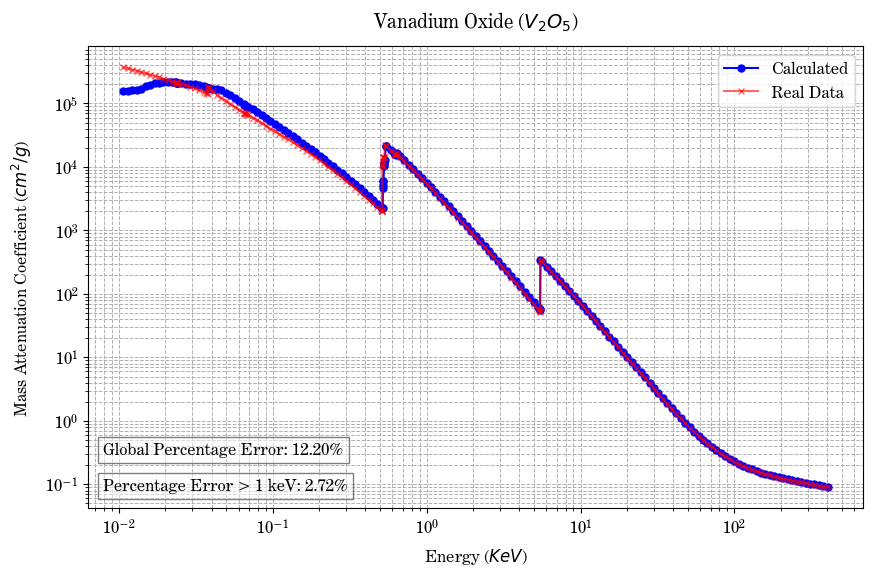

Plot saved as Vanadium Oxide ($V_2O_5$).png


In [6]:
directory = 'BUILD/ROOT/'

csv_1 = 'vana5.csv'
x_branch_1 = "Energy"
y_branch_1 = 'AtCoefficient'

csv_2 = 'V2O5nist2.csv'
x_branch_2 = "Energy"
y_branch_2 = 'Coeff'

title = r"Vanadium Oxide ($V_2O_5$)"
x_label = r"Energy ($KeV$)"
y_label = r"Mass Attenuation Coefficient ($cm^2/g$)"

plot_jp(directory, csv_1, x_branch_1, y_branch_1, csv_2, x_branch_2, y_branch_2, title, x_label, y_label)

### Plot energy vs thickness

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_jp2(directory, csv_1, x_branch_1, y_branch_1, title, x_label, y_label):

    path_1 = os.path.join(directory, csv_1)    
    df_1 = pd.read_csv(path_1)

    x1 = df_1[x_branch_1]
    y1 = df_1[y_branch_1]

    plt.figure(figsize=(10, 6))
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    
    SIZE_DEFAULT = 12
    SIZE_LARGE = 14

    plt.rc("font", family = 'Century Expanded')  
    plt.rc("font", weight = "normal")  
    plt.rc("font",  size      = SIZE_DEFAULT)  
    plt.rc("axes",  titlesize = SIZE_LARGE  )  
    plt.rc("axes",  labelsize = SIZE_DEFAULT)  
    plt.rc("xtick", labelsize = SIZE_DEFAULT)  
    plt.rc("ytick", labelsize = SIZE_DEFAULT)  

    plt.plot(x1, y1, marker = 'o', markersize = 5, label = 'Calculated', color = 'blue')

    plt.xscale('log')
    plt.yscale('log')

    # plt.xlim(.01, 1)
    # plt.ylim(1000, 250000)

    plt.xlabel(x_label, labelpad = 7)
    plt.ylabel(y_label, labelpad = 8)
    plt.title(title, pad = 14)
    plt.legend()

    plt.savefig(title + '_thickness' + '.png', dpi = 400)
    plt.show()

    print('Plot saved as', title + '.png')

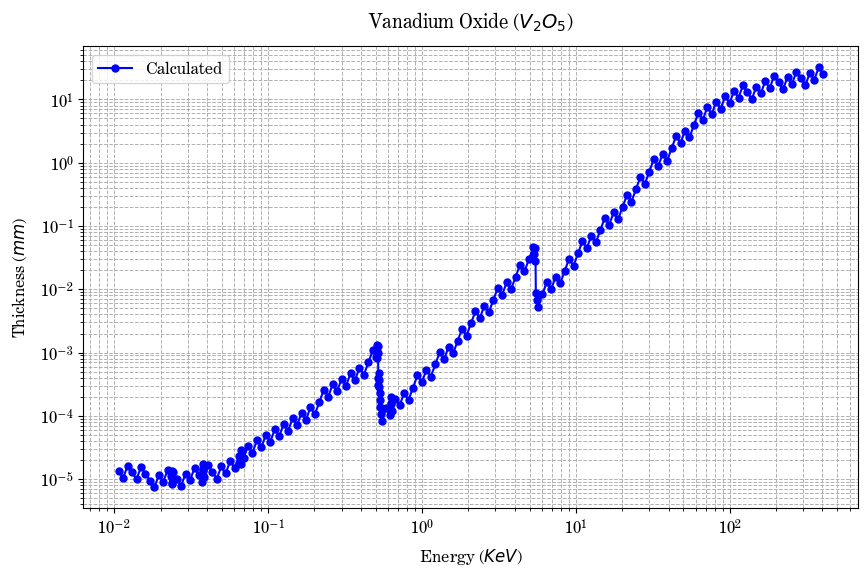

Plot saved as Vanadium Oxide ($V_2O_5$).png


In [8]:
directory = 'BUILD/ROOT/'

csv_1 = 'vana5.csv'
x_branch_1 = "Energy"
y_branch_1 = 'Optimal_Thickness'

title = r"Vanadium Oxide ($V_2O_5$)"
x_label = r"Energy ($KeV$)"
y_label = r"Thickness ($mm$)"

plot_jp2(directory, csv_1, x_branch_1, y_branch_1, title, x_label, y_label)